Карацапова Ирина, 396

<h1 align="center">Check Questions</h1> 

Ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: Чем отличается AdaBoost от XGBoost? Перечислите принципиальные отличия. 

XGBoost менее склонен к переобучению за счет того, что добавляются штрафы за количество листьев и норму коэффициентов. Он приближает направление, посчитанное с учетом второй, а не первой производной функции потерь. AdaBoost менее устойчив к выбросам.

**Вопрос 2**: Почему говорят, что AdaBoost неустойчив к выбросам?

Алгоритм стремится максимально исправить ошибки на обучении на каждой своей итерации. Но это бессмысленное занятие при наличие выбросов и ведет лишь к переобучению

**Вопрос 3**:  В каком пространстве градиентный бустинг совершает градиентный спуск? Какова размерность этого пространства?

Градиентный бустинг совершает градиентный спуск в пространстве всех возможных алгоритмов.

**Вопрос 4**: В чем заключается сокращение шага в градиентном бустинге? Как число итераций, необходимое для сходимости, зависит от размера шага η?

Сокращение шага уменьшает склонность к переобучению, заключается в том, как сильно учитывается каждое новое слагаемое. Чем меньше размер шага, тем больше нужно число итераций.

**Вопрос 5**: Что такое стохастический градиентный бустинг?

Это градиентный бустинг, где на каждом шаге алгоритма новое слагаемое считается, опираясь на случайную подвыборку объектов и/или признаков.

-----------
PS: Если проверяющий не понял ответ на большинство вопросов, то будет пичалька. Пишите так, чтобы можно было разобраться. 

<h1 align="center">Boosting</h1> 

1) Задача 1 
![](./img/task11.png)
![](./img/task12.png)

Можно взять алгоритмы, такие что каждый из них будет классифицировать один объект (выдавать ответ 1 или -1), а на всех остальных выдавать 0. При этом коэффициент взять равным 1. Таким образом, понадобится l алгоритмов.

2) Найдите градиент логистичиской функции потерь для фиксированного объекта

![](./img/answer_1_1.png)
![](./img/answer_1_2.png)

<h1 align="center">Binary Boosting Implementation</h1> 

Нужно реализовать двухклассовый бустинг с логистичиской функцией потерь. 

Длину шага -- или используйте $1.0*lr$ или подбирайте одномерной оптимизацией;

In [1]:
%pylab inline

import warnings
import numpy as np
import pandas as pd
from copy import deepcopy
from utils2 import plot_surface
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
class BinaryBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, base_estimator=DecisionTreeRegressor(min_samples_leaf=5, max_depth=5), lr=0.1):
        self.lr = lr   
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator
    
    def loss_grad(self, original_y, pred_y):
        grad = np.zeros(len(original_y))
        grad = original_y / (1 + exp(original_y * pred_y))
#         grad = log(1 + exp(-original_y * pred_y))
        return grad # Градиент на кажом объекте
        
    def fit(self, X, original_y):
        # Храните базовые алгоритмы тут
        self.estimators_ = [] 
        
        for i in range(self.n_estimators):
            grad = self.loss_grad(original_y, self._predict(X))
            # Настройте базовый алгоритм на градиент, это классификация или регрессия?
            estimator = deepcopy(self.base_estimator) 
            self.estimators_.append(estimator.fit(X, grad))
        
        self.out_ = self.outliers(grad)

        return self

    def _predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for estimator in self.estimators_:
            y_pred = y_pred + self.lr * estimator.predict(X)
        return y_pred
    
    def predict(self, X):
        y_pred = self._predict(X)
        y_pred = np.array(list(map(lambda x: -1.0 if x < 0 else 1.0, y_pred)))
        return y_pred
#         y_pred = <примените к self._predict решающее правило>
#         return y_pred
    
    def outliers(self, grad):
        abs_grad = abs(grad)
        return abs_grad.argsort()[-10:][::-1]
#         return # Топ-10 объектов с большим отступом

<h1 align="center">Simple test</h1> 

In [84]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
y = 2*(y-0.5)

In [85]:
# print(X)
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, y_train, X_test, y_test = X[:train_size], y[:train_size], X[train_size:], y[train_size:]

0.922857142857 0.76


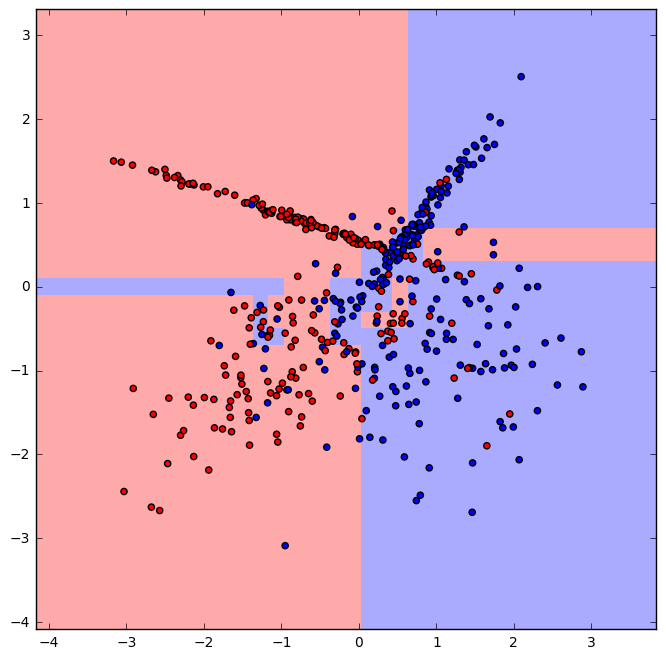

In [98]:
clf = BinaryBoostingClassifier().fit(X_train, y_train)
print(accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test))
plot_surface(X, y, clf)

<h1 align="center">Outliers</h1> 

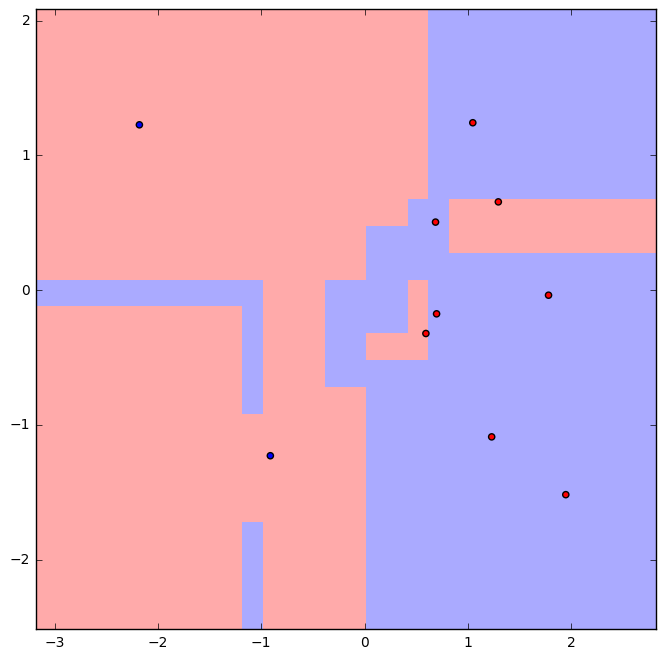

In [21]:
# <Нарисуйте только outliers> 
plot_surface(X[clf.out_], y[clf.out_], clf)

<h1 align="center">Adult test</h1> 

In [ ]:
!sh ./get_data.sh

In [25]:
adult = pd.read_csv(
    './data/adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")
adult = pd.get_dummies(adult)
adult["Target"] = adult["Target_ >50K"]

In [26]:
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values
y = 2*(y-0.5)

In [27]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, y_train, X_test, y_test = X[:train_size], y[:train_size], X[train_size:], y[train_size:]

In [10]:
# <Сверьте качество своего алгоритма с GradientBoostingClassifier>
clf = BinaryBoostingClassifier().fit(X_train, y_train)
print(accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test))
clf_grad = GradientBoostingClassifier().fit(X_train, y_train)
print(accuracy_score(clf_grad.predict(X_train), y_train), accuracy_score(clf_grad.predict(X_test), y_test))

0.861793611794 0.861705394616
0.868857493857 0.868563824342


BinaryBoostingClassifier() работает чуть хуже, чем GradientBoostingClassifier()

<h1 align="center">Text classification</h1> 

- Найдите двухклассовый текстовый датасет (в качестве примера sentiment analysis) или возьмите многоклассовый и классифцируйте один клас против остальных
- Попробуйте бустинг на решающих деревьях, в качестве фичей используйте tf-idf и svd/random_projection/hashing_trick, что работает лучше? Сравните качество и время работы.

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [49]:
vectorizer = TfidfVectorizer()
X_train_tfidf, y_train_tfidf = vectorizer.fit_transform(newsgroups_train.data), newsgroups_train.target
X_test_tfidf,  y_test_tfidf  = vectorizer.transform(newsgroups_test.data), newsgroups_test.target

In [50]:
max_class = max(y_train_tfidf)
min_class = min(y_train_tfidf)
class_line = int( (max_class + min_class) / 2)
# class_line = int(max_class / 2)
y_train = list(map(lambda x: -1 if x < class_line else 1, y_train_tfidf))
y_test = list(map(lambda x: -1 if x < class_line else 1, y_test_tfidf))

<b> tf-idf + svd

In [51]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5, random_state=42)
X_train = svd.fit_transform(X_train_tfidf)
X_test = svd.fit_transform(X_test_tfidf)

In [52]:
%%time
clf = BinaryBoostingClassifier().fit(X_train, y_train)
clf.predict(X_train)
print(accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test))

0.820399505038 0.687334041423
CPU times: user 5.76 s, sys: 13 ms, total: 5.77 s
Wall time: 5.79 s


<b>tf-idf + random_projection

In [41]:
from sklearn import random_projection

transformer = random_projection.SparseRandomProjection()
X_train = transformer.fit_transform(X_train_tfidf)
X_test = transformer.fit_transform(X_test_tfidf)

In [42]:
number_train = 400
number_test = 100
X_test = X_train[number_train : (number_train + number_test)]
y_test = y_train[number_train : (number_train + number_test)]
X_train = X_train[:number_train]
y_train = y_train[:number_train]

In [46]:
%%time
clf = BinaryBoostingClassifier().fit(X_train, y_train)
clf.predict(X_train)
print(accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test))

1.0 0.76
CPU times: user 1min 7s, sys: 2.67 s, total: 1min 10s
Wall time: 1min 10s


<b>tf-idf + hashing_trick

In [47]:
from sklearn.feature_extraction.text import HashingVectorizer

hv = HashingVectorizer()
X_train, y_train = hv.fit_transform(newsgroups_train.data), newsgroups_train.target
X_test, y_test = hv.transform(newsgroups_test.data), newsgroups_test.target

max_class = max(y_train)
min_class = min(y_train)
class_line = int( (max_class + min_class) / 2)
y_train = list(map(lambda x: -1 if x < class_line else 1, y_train))
y_test = list(map(lambda x: -1 if x < class_line else 1, y_test))

number_train = 400
number_test = 100
X_train = X_train[:number_train]
y_train = y_train[:number_train]
X_test = X_test[:number_test]
y_test = y_test[:number_test]

In [48]:
%%time
clf = BinaryBoostingClassifier().fit(X_train, y_train)
clf.predict(X_train)
print(accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test))

0.9725 0.73
CPU times: user 1min 6s, sys: 15.5 s, total: 1min 22s
Wall time: 1min 22s


Качество у random_projection и hashing_trick выше, но время во много раз больше (на полных данных не удалось дождаться окончания расчета, пришлось работать с подвыборкой).

<h1 align="center">Random Forest vs Boosting</h1> 

Подберите 2+ датасета как минимум большой и маленький (не использованных в этом дз) и проведите сравнение random forest и градиентного бустинга, используйте реализации алгоритмов из библиотеки sklearn.

- Опишите результаты, почему тот или другой алгоритм на конкретном датасете работает лучше/хуже?
- Как вы настраивали гиперпараметры алгоритмов?
- Как вы проверяли качесво алгоритмов?

<h2> Titanic

In [179]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

titanic = pd.read_csv('./data/titanic.csv')[['Survived', 'Pclass', 'Sex', 'Age', 'Fare']]

sex_encoder = LabelEncoder()
titanic.Sex = sex_encoder.fit_transform(titanic.Sex)
features = ['Pclass', 'Sex', 'Age', 'Fare']

In [180]:
X, y = titanic[features].values, titanic.Survived.values
X = np.nan_to_num(X)
X_train, y_train, X_test, y_test = X[:500], y[:500], X[500:], y[500:]

<b>Boosting

In [181]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
print(accuracy_score(gbc.predict(X_train), y_train), accuracy_score(gbc.predict(X_test), y_test))

0.916 0.818414322251


In [97]:
%%time

learning_rates = np.arange(0.01, 0.11, 0.01)
n_estimatorss = np.arange(100, 1050, 100)
accs = []
for learning_rate in learning_rates:
    accs_line = []
    for n_estimators in n_estimatorss:
        try:
            gbc = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = n_estimators)
            gbc.fit(X_train, y_train)
            acc = accuracy_score(gbc.predict(X_test), y_test)
            accs_line.append(int(acc*10000)/10000)
        except ValueError:
            accs_line.append(0)
    accs.append(accs_line)
    
# for accs_line in accs:
#     print(accs_line)

accs_learning_rate = [max(accs_line) for accs_line in accs]
learning_rate_index = accs_learning_rate.index(max(accs_learning_rate))
learning_rate_best = learning_rates[learning_rate_index]

accs_n_estimators = accs[learning_rate_index]
n_estimators_index = accs_n_estimators.index(max(accs_n_estimators))
n_estimators_best = n_estimatorss[n_estimators_index]

acc_best = accs[learning_rate_index][n_estimators_index]

print(learning_rate_best, n_estimators_best)

gbc = GradientBoostingClassifier(learning_rate = learning_rate_best, n_estimators = n_estimators_best)
gbc.fit(X_train, y_train)
print(accuracy_score(gbc.predict(X_train), y_train), accuracy_score(gbc.predict(X_test), y_test))

0.05 400
0.95 0.831202046036
CPU times: user 30.9 s, sys: 84.4 ms, total: 31 s
Wall time: 31.1 s


<b>Random Forest

In [182]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(accuracy_score(rfc.predict(X_train), y_train), accuracy_score(rfc.predict(X_test), y_test))

0.974 0.79283887468


In [183]:
n_estimatorss = np.arange(50, 500, 50)
accs = []
for n_estimators in n_estimatorss:
    rfc = RandomForestClassifier(n_estimators = n_estimators)
    rfc.fit(X_train, y_train)
    acc = accuracy_score(rfc.predict(X_test), y_test)
    accs.append(acc)
n_estimators_best = n_estimatorss[accs.index(max(accs))]
print(n_estimators_best)

rfc = RandomForestClassifier(n_estimators = n_estimators_best)
rfc.fit(X_train, y_train)
print(accuracy_score(rfc.predict(X_train), y_train), accuracy_score(rfc.predict(X_test), y_test))

350
0.988 0.800511508951


<h2>Credit

In [184]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

credit = pd.read_csv('./data/credit.csv')
credit = credit.dropna()

X, y = credit.drop('Label', 1), credit['Label']
print(len(y))

train_size = int(len(X) * 0.7)
X_train, y_train, X_test, y_test = X[:train_size], y[:train_size], X[train_size:], y[train_size:]

39931


<b>Boosting

In [185]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
print(accuracy_score(gbc.predict(X_train), y_train), accuracy_score(gbc.predict(X_test), y_test))

0.938821509069 0.910350584307


In [188]:
%%time

learning_rates = np.arange(0.01, 0.12, 0.02)
n_estimatorss = np.arange(100, 1050, 100)
accs = []
for learning_rate in learning_rates:
    accs_line = []
    for n_estimators in n_estimatorss:
        try:
            gbc = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = n_estimators)
            gbc.fit(X_train, y_train)
            acc = accuracy_score(gbc.predict(X_test), y_test)
            accs_line.append(int(acc*10000)/10000)
        except ValueError:
            accs_line.append(0)
    accs.append(accs_line)
    
# for accs_line in accs:
#     print(accs_line)

accs_learning_rate = [max(accs_line) for accs_line in accs]
learning_rate_index = accs_learning_rate.index(max(accs_learning_rate))
learning_rate_best = learning_rates[learning_rate_index]

accs_n_estimators = accs[learning_rate_index]
n_estimators_index = accs_n_estimators.index(max(accs_n_estimators))
n_estimators_best = n_estimatorss[n_estimators_index]

acc_best = accs[learning_rate_index][n_estimators_index]

print(learning_rate_best, n_estimators_best)

gbc = GradientBoostingClassifier(learning_rate = learning_rate_best, n_estimators = n_estimators_best)
gbc.fit(X_train, y_train)
print(accuracy_score(gbc.predict(X_train), y_train), accuracy_score(gbc.predict(X_test), y_test))

0.01 200
0.934313620264 0.938397328881
CPU times: user 10min 21s, sys: 3.78 s, total: 10min 25s
Wall time: 10min 31s


<b>Random Forest

In [186]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(accuracy_score(rfc.predict(X_train), y_train), accuracy_score(rfc.predict(X_test), y_test))

0.990698007227 0.921702838063


In [187]:
%%time

n_estimatorss = np.arange(50, 500, 50)
accs = []
for n_estimators in n_estimatorss:
    rfc = RandomForestClassifier(n_estimators = n_estimators)
    rfc.fit(X_train, y_train)
    acc = accuracy_score(rfc.predict(X_test), y_test)
    accs.append(acc)
n_estimators_best = n_estimatorss[accs.index(max(accs))]
print(n_estimators_best)

rfc = RandomForestClassifier(n_estimators = n_estimators_best)
rfc.fit(X_train, y_train)
print(accuracy_score(rfc.predict(X_train), y_train), accuracy_score(rfc.predict(X_test), y_test))

300
1.0 0.935642737896


Итак, результаты градиентного бустинга превосходят результаты случайного леса.
<br> (гиперпараметры настраивались квадратичным перебором, качество проверялось accuracy_score)

<h1 align="center">Bonus part</h1> 

Это удвоит баллы за дз.

- Реализуйте мультиклассовый бустинг -- проверьте на CIFAR10 + SVD
- Попробуйте различные функции потерь, придумайте несколько своих, удалось ли обойти логистичискую и экспоненциальную?